## 4.3 스케일링

이 절에서는 회귀분석에 있어 필수적인 스케일링의 목적과 방법에 대해 공부한다.

### 조건수

보스턴 집값 데이터 예측문제를 statsmodels 패키지로 풀어 summary 리포트를 출력해보자. 

In [1]:
from sklearn.datasets import load_boston

boston = load_boston()

dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)

model1 = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sun, 05 Jul 2020   Prob (F-statistic):          6.72e-135
Time:                        13:20:08   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

가장 하단에 다음과 같은 경고 메세지를 볼 수 있다. 

```
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
```

해석하면 다음과 같다.

```
조건수(conditiona number)가 15100으로 너무 큽니다. 
강한 다중공선성(multicollinearity)이나 다른 수치적 문제가 있을 수 있습니다.
```

행렬의 **조건수**(conditional number)는 가장 큰 고유치와 가장 작은 고유치의 비율을 뜻한다. 회귀분석에서는 공분산행렬 $X^TX$의 가장 큰 고유치와 가장 작은 고유치의 비율이 된다.

$$ \text{condition number} = \dfrac{\lambda_{\text{max}}}{\lambda_{\text{min}}} $$

여기에서는 다음 연립방정식을 예로 들어 설명을 하겠다.

$$ Ax = b $$

이런 연립방정식이 있을 때 행렬 $A$의 조건수가 크면 계수행렬 $A$와 상수벡터 $b$에 대한 해 $x$의 민감도가 커지고 따라서 계수행렬이나 상수벡터에 존재하는 오차가 해에 미치는 영향이 커진다. 


조건수는 가장 작은 경우의 예는 행렬 $A$가 단위 행렬인 경우다. 이 때 조건수의 값은 1이다.

$$ \text{cond}(I) = 1 $$

In [2]:
A = np.eye(4)

이 행렬 $A$와 곱해져서 상수 벡터 $b$가 되는 벡터 $x$를 역행렬 $A^{-1}$을 사용하여 계산할 수 있다. 이 예에서는 상수 벡터 $b$가 1-벡터이다.

In [3]:
b = np.ones(4)
x = sp.linalg.solve(A, b)
x

array([1., 1., 1., 1.])

만약 상수 벡터에 약간의 오차가 있었다면 연립방정식의 해에도 동일한 수준의 오차가 발행한다. 다음 코드과 실행결과는 행렬 $A$에 1/10000 오차가 있으면 해 $x$에도 유사한 정도의 오차가 생기는 것을 보이고 있다.

In [4]:
x_error = sp.linalg.solve(A + 0.0001 * np.eye(4), b)
x_error

array([0.99990001, 0.99990001, 0.99990001, 0.99990001])

이번에는 다음과 같은 행렬을 생각하자. 

In [5]:
A = sp.linalg.hilbert(4)
A

array([[1.        , 0.5       , 0.33333333, 0.25      ],
       [0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.25      , 0.2       , 0.16666667, 0.14285714]])

이 행렬은 4차 힐버트 행렬(Hilbert matrix)이라는 행렬로 조건수가 15000이 넘는다.

In [6]:
np.linalg.cond(A)

15513.738738929038

이렇게 연립방정식을 이루는 행렬의 조건수가 커지면 상수항 오차가 작은 경우에도 해의 오차가 커지게 된다. 오차가 없는 경우의 해 $x$는 다음과 같다.

In [7]:
sp.linalg.solve(A, b)

array([  -4.,   60., -180.,  140.])

하지만 이 경우에는 계수행렬이나 상수벡터에 약간의 오차만 있어도 해가 전혀 다른 값을 가진다. 다음 코드는 계수행렬에 1/10000의 오차가 있을 때 해의 값이 전혀 달라지는 것을 보인다.

In [8]:
sp.linalg.solve(A + 0.0001 * np.eye(4), b)

array([ -0.58897672,  21.1225671 , -85.75912499,  78.45650825])

따라서 **공분산행렬 $X^TX$의  조건수가 크면 회귀분석을 사용한 예측값도 오차가 커진다.**

### 회귀분석과 조건수

회귀분석에서 조건수가 커지는 경우는 크게 두 가지가 있다.

1. 변수들의 단위 차이로 인해 숫자의 스케일이 크게 달라지는 경우. 이 경우에는 스케일링(scaling)으로 해결한다.
1. 다중 공선성 즉, 상관관계가 큰 독립 변수들이 있는 경우, 이 경우에는 변수 선택이나 PCA를 사용한 차원 축소 등으로 해결한다.

이를 독립변수의 분포모양으로 설명하면 다음 그림과 같다.

In [9]:
%load_ext tikzmagic

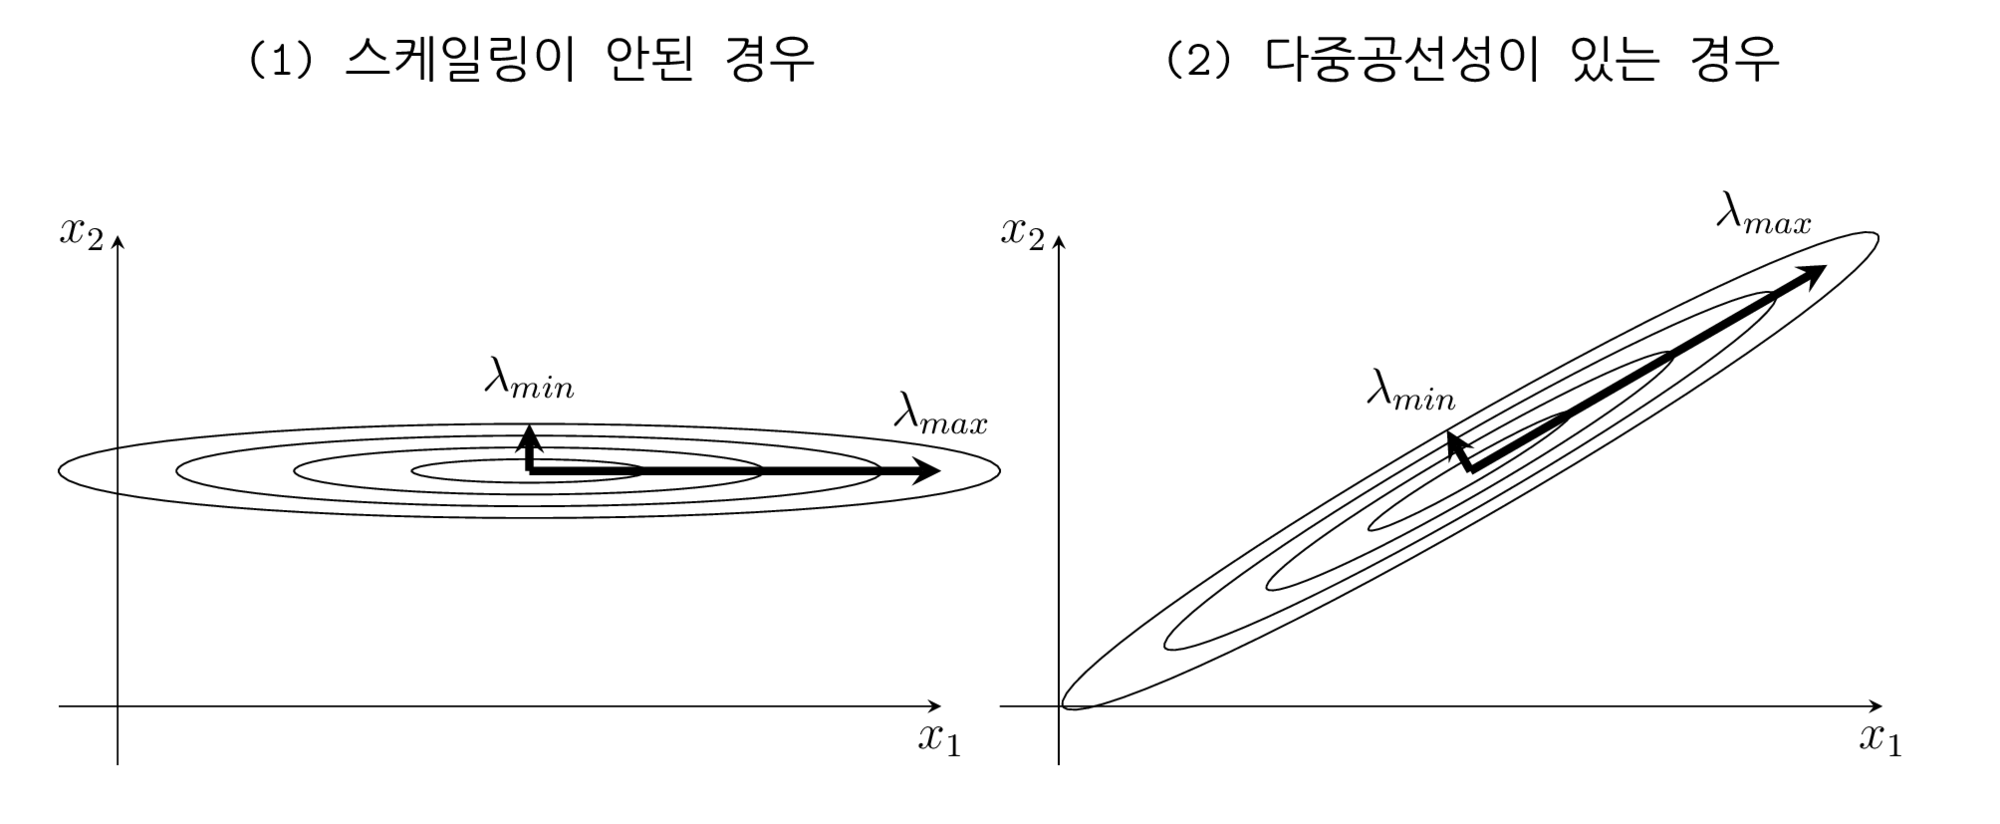

In [10]:
%%tikz -p kotex,pgfplots -l arrows.meta,calc -s 2000,1200 -f png

\coordinate (leftbottom) at (0,0);
\coordinate (righttop) at (17,7);
\fill[white,use as bounding box] (leftbottom) rectangle (righttop);
\draw[help lines, white] (leftbottom) grid (righttop);
\tikzset{
    >=stealth,font={\ttfamily\large}
}

\node at (4.5,6.5) {(1) 스케일링이 안된 경우};
\draw[->] (0.5,1) -- (8,1);
\draw[->] (1,0.5) -- (1,5);
\node at (8,0.7) {$x_1$}; 
\node at (0.7,5) {$x_2$}; 
\draw (4.5,3) circle (1cm and 0.1cm);
\draw (4.5,3) circle (2cm and 0.2cm);
\draw (4.5,3) circle (3cm and 0.3cm);
\draw (4.5,3) circle (4cm and 0.4cm);
\draw[->, line width=2pt] (4.5,3) -- (8,3);
\draw[->, line width=2pt] (4.5,3) -- (4.5,3.4);
\node at (8,3.5) {$\lambda_{max}$};
\node at (4.5,3.8) {$\lambda_{min}$};

\node at (12.5,6.5) {(2) 다중공선성이 있는 경우};
\draw[->] (8.5,1) -- (16,1);
\draw[->] (9,0.5) -- (9,5);
\node at (16,0.7) {$x_1$}; 
\node at (8.7,5) {$x_2$}; 
\begin{scope}[shift={(12.5,3)},rotate=30]
\draw (0,0) circle (1cm and 0.1cm);
\draw (0,0) circle (2cm and 0.2cm);
\draw (0,0) circle (3cm and 0.3cm);
\draw (0,0) circle (4cm and 0.4cm);
\draw[->, line width=2pt] (0,0) -- (3.5,0);
\draw[->, line width=2pt] (0,0) -- (0,0.4);
\end{scope}
\node at (15,5.2) {$\lambda_{max}$};
\node at (12,3.7) {$\lambda_{min}$};

보스턴 집값 문제의 경우 각 독립변수들이 0.1 수준부터 100 수준까지 제각각의 크기를 가지고 있기 때문이다.

In [11]:
dfX.describe().loc["std"]

CRIM         8.601545
ZN          23.322453
INDUS        6.860353
CHAS         0.253994
NOX          0.115878
RM           0.702617
AGE         28.148861
DIS          2.105710
RAD          8.707259
TAX        168.537116
PTRATIO      2.164946
B           91.294864
LSTAT        7.141062
Name: std, dtype: float64

이렇게 독립변수가 스케일링 안되면 조건수가 커져서 예측 오차가 증폭될 가능성이 커진다. 이 효과를 확실하게 보기 위하여 일부러 다음처럼 TAX 변수를 크게 만들어 조건수를 증폭시켜 보았다. 

In [12]:
dfX2 = dfX.copy()
dfX2["TAX"] *= 1e13
df2 = pd.concat([dfX2, dfy], axis=1)

model2 = sm.OLS.from_formula("MEDV ~ " + "+".join(boston.feature_names), data=df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     83.39
Date:                Sun, 05 Jul 2020   Prob (F-statistic):           8.62e-44
Time:                        13:20:18   Log-Likelihood:                -1737.9
No. Observations:                 506   AIC:                             3484.
Df Residuals:                     502   BIC:                             3501.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0038      0.000     -8.543      0.0

조건수가 1000조 수준으로 증가한 것을 볼 수 있다. `R-squared`로 표시되는 성능지표도 크게 감소하였다. 이 성능지표에 대해서는 추후 분산분석에서 자세히 다룬다.

statsmodels에서는 모형지정 문자열에서 `scale()` 명령을 사용하여 스케일링을 할 수 있다. 이 방식으로 스케일을 하면 스케일링에 사용된 평균과 표준편차를 저장하였다가 나중에 `predict()` 명령을 사용할 때도 같은 스케일을 사용하기 때문에 편리하다. 카테고리 더미변수인 `CHAS`는 스케일을 하지 않는다는 점에 주의한다.

In [13]:
feature_names = list(boston.feature_names)
feature_names.remove("CHAS") 
feature_names = ["scale({})".format(name) for name in feature_names] + ["CHAS"]
model3 = sm.OLS.from_formula("MEDV ~ " + "+".join(feature_names), data=df2)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sun, 05 Jul 2020   Prob (F-statistic):          6.72e-135
Time:                        13:20:19   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.3470      0.219    101.

스케일링만으로 조건수가 10.6이 된 것을 확인할 수 있다.